In [8]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [4]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [5]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from make_line import make_data, get_grid, get_code

In [25]:
# x  (None,64,64)
# y0 (None,8,8,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None, (8,8) or 64,64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=1024)
x_val, y_val0, y_val1 = make_data(N=100)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

[[4 1]
 [4 5]]
33 4 8 1 0
37 4 8 5 0


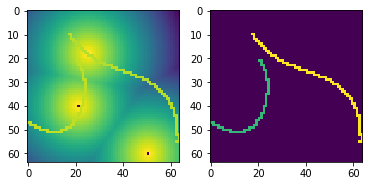

In [26]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,:,-1]==1)
print(region)
tmp = np.zeros((szx,szy))
r=1
if len(region.squeeze().shape) > 0:
    for x,y in region:
        code = smx*x+y
        print(code,x,smx,y,np.sum(y_train1[ind,x,y,code]))
        tmp[y_train1[ind,:,:,code].squeeze()==1]=r+1
        r+=1
plt.subplot(122)
plt.imshow(tmp)

In [27]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers


In [28]:
def viz_results(x_test,y_test0,ytest1,pred,szx,szy):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))
        #print(pred[0][ind,:,:,obj_ind])
        maxval = np.max(pred[0][ind,:,:,obj_ind])
        argmax = np.argwhere(pred[0][ind,:,:,obj_ind]==maxval)
        argmaxx,argmaxy=argmax[0]
        print(print(argmax.shape),argmax[0])
        
        print('pred',pred[0][ind,argmaxx,argmaxy,:])
        print('true',y_test0[ind,argmaxx,argmaxy,:])
        print('------')
        
        # GROUND TRUTH
        sa=plt.subplot(331)
        plt.title('sample index: {}, t:green, p:blue'.format(ind))
        sa.imshow(x_test[ind,:].squeeze())
        
        # overlay bounding box
        argmax = get_code(argmaxx,argmaxy,smx)
        ax,ay=grid_anchor[argmax]
        x,y,w,h,o = pred[0][ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='b',facecolor='none')
        sa.add_patch(rect)
        
        x,y,w,h,o = y_test0[ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='g',facecolor='none')
        sa.add_patch(rect)
        
        obj_real = y_test0[ind,:,:,obj_ind].squeeze()
        
        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        
        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(obj_real.ravel())
        ax.set_ylim(0,1)
        
        # PREDICTED
        
        obj = pred[0][ind,:,:,obj_ind].squeeze()
        
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')
        
        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(obj.ravel())
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,argmaxx,argmaxy,:,:].squeeze(),cmap='gray')
            

In [209]:

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

# actual yolos
#   https://pjreddie.com/media/files/papers/YOLO9000.pdf GOOD, others are helpful
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2
#   https://hackernoon.com/understanding-yolo-f5a74bbc7967
# simple yolo # less intimidating, but not useable, good for intro.
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO

epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1]))

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0],y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1],y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2],y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3],y_pred[...,3])
    
    loss_pos = tf.add(loss_px,loss_py)
    loss_width = tf.add(loss_wx,loss_wy)
    
    coord_loss = tf.add(loss_pos,loss_width)
    coord_loss = tf.multiply(y_true[...,-1],coord_loss)
    return tf.reduce_mean(coord_loss)

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], 1. - tf.truediv(2.*intersect_areas,(union_areas+epsilon)) )
    
    return tf.reduce_mean(iou_loss)

def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 0.1
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=1):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

inputs = Input(shape=(szx,szy,1))

dropoutrate = 0.4
# down sample
xd = conv_batch_lrelu(inputs, 16, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 32, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 64, 3)
xd = conv_batch_lrelu(xd, 32, 1)
xd = conv_batch_lrelu(xd, 64, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)

xd = conv_batch_lrelu(xd, 128, 3)
xd = conv_batch_lrelu(xd, 64, 1)
xd = conv_batch_lrelu(xd, 128, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 64, 1)
xd = conv_batch_lrelu(xd, 128, 3)
xd = Conv2D(5, (1, 1), strides=1, padding='same',use_bias=False)(xd)                        
vecs=Activation('sigmoid')(xd)

model = Model(inputs=inputs, outputs=vecs)
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 64, 64, 16)        144       
_________________________________________________________________
batch_normalization_332 (Bat (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_332 (LeakyReLU)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_138 (Dropout)        (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_375 (Conv2D)          (None, 32, 32, 32)        4608      
__________

In [210]:
# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py
# opt.Adam, opt.RMSprop
verbose=1
batch_size=32
epochs=1000
lr=1E-3
decay=1E-3
patience=10
beta_1=0.9
beta_2=0.999

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]
optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=vec_loss, optimizer=optimizer)
history = model.fit(x_train, y_train0,
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(x_val, y_val0),
                    callbacks=callbacks)
# 0.079,;.22
# added dropout to 0.5:
# 0.11,0.15
# added layer at front to perhaps dilate line:
# 0.06, 0.15 # remove, since overfits.
# increased dropout to 0.7:
# 0.1091,0.1091 # wow... but why...?# obj map looks blurred.
# increased dropout to 0.99:
# 0.16,0.15 # obj map is all white now :D
# found a bug, iou loss needs to be 1-iou!:
# 0.10,0.18 # new ref.
## varying loss weights, obj:coord:iou=1:0.1:1 :
0.11,0.16

Train on 1024 samples, validate on 100 samples
Epoch 1/1000
1024/1024 [==============================] - 15s 15ms/step - loss: 1.3792 - val_loss: 1.1635
Epoch 2/1000
1024/1024 [==============================] - 1s 776us/step - loss: 1.0314 - val_loss: 0.9401
Epoch 3/1000
1024/1024 [==============================] - 1s 803us/step - loss: 0.8587 - val_loss: 0.8007
Epoch 4/1000
1024/1024 [==============================] - 1s 801us/step - loss: 0.7317 - val_loss: 0.7020
Epoch 5/1000
1024/1024 [==============================] - 1s 821us/step - loss: 0.6287 - val_loss: 0.6060
Epoch 6/1000
1024/1024 [==============================] - 1s 791us/step - loss: 0.5458 - val_loss: 0.5218
Epoch 7/1000
1024/1024 [==============================] - 1s 825us/step - loss: 0.4759 - val_loss: 0.4621
Epoch 8/1000
1024/1024 [==============================] - 1s 799us/step - loss: 0.4184 - val_loss: 0.4151
Epoch 9/1000
1024/1024 [==============================] - 1s 796us/step - loss: 0.3712 - val_loss: 0.3709

(0.11, 0.16)

dict_keys(['val_loss', 'loss'])

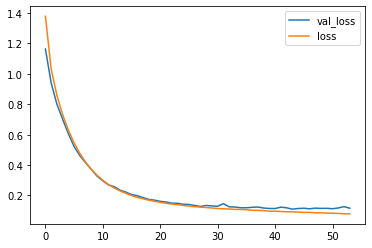

In [211]:
df = pd.DataFrame(history.history)
df.plot()
history.history.keys()

In [214]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = model.evaluate(x_0,y_0)
print('test',out)

1024/1024 [==============================] - 0s 339us/step
train 0.06625390576664358
100/100 [==============================] - 0s 483us/step
val 0.11604440540075302
5/5 [==============================] - 0s 2ms/step
test 0.15271535515785217


(1, 2)
None [2 2]
pred [0.05288798 0.08449993 0.32187006 0.654013   0.85648006]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [1 5]
pred [0.09968042 0.07015547 0.38188493 0.35661602 0.46899733]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [5 5]
pred [0.05115858 0.05517155 0.4601858  0.5503973  0.78343827]
true [0.109375 0.       0.5      0.375    1.      ]
------
(1, 2)
None [2 6]
pred [0.07969388 0.01504612 0.36008573 0.35121405 0.7026725 ]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [2 1]
pred [0.11772907 0.08282009 0.3825259  0.35371822 0.6067663 ]
true [0.0859375 0.1171875 0.484375  0.453125  1.       ]
------


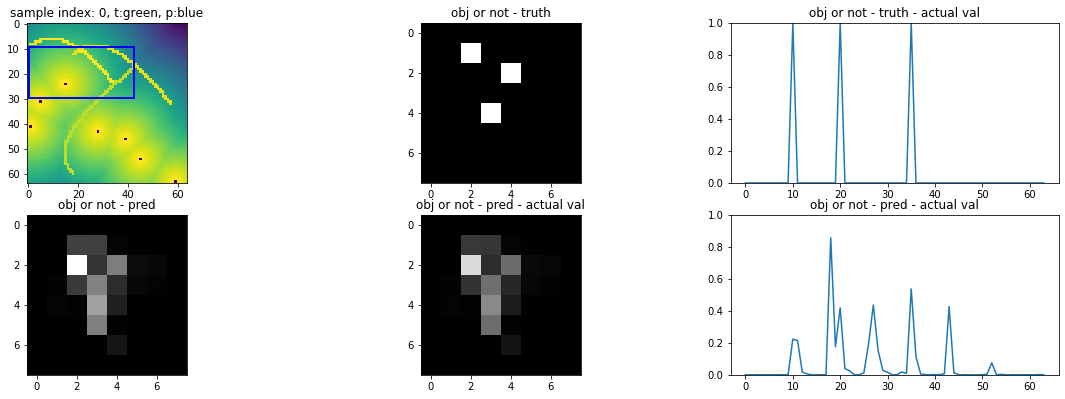

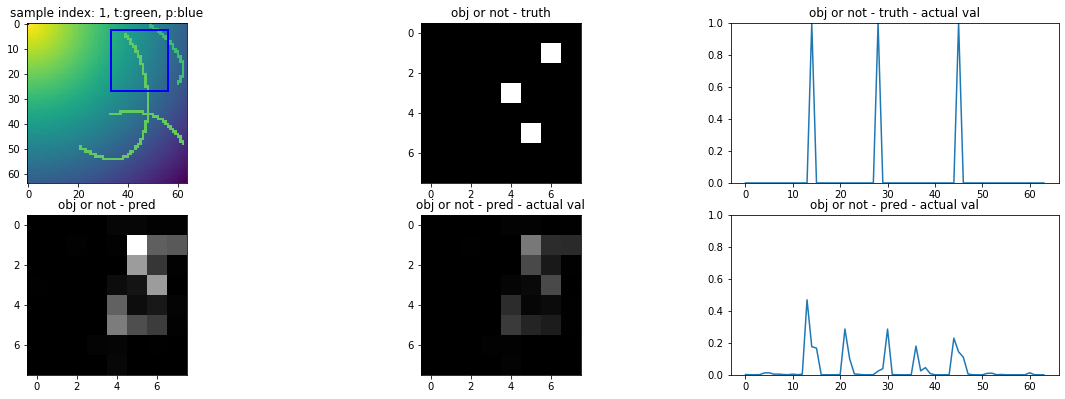

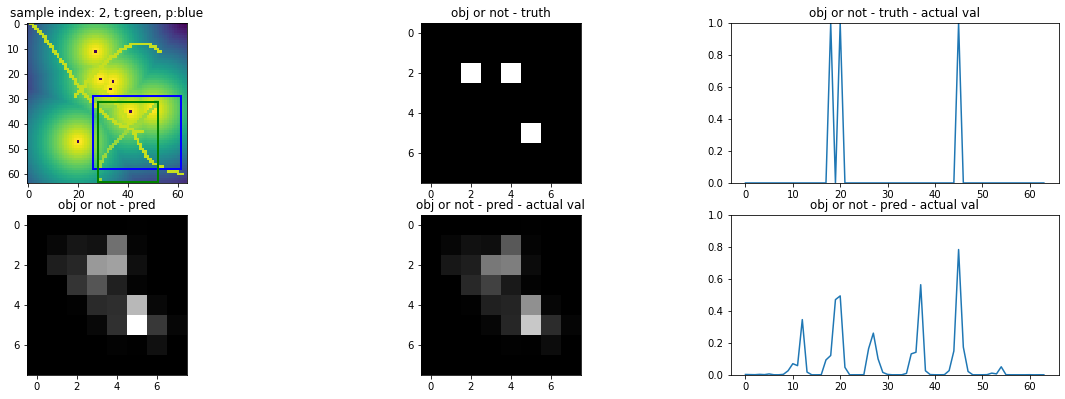

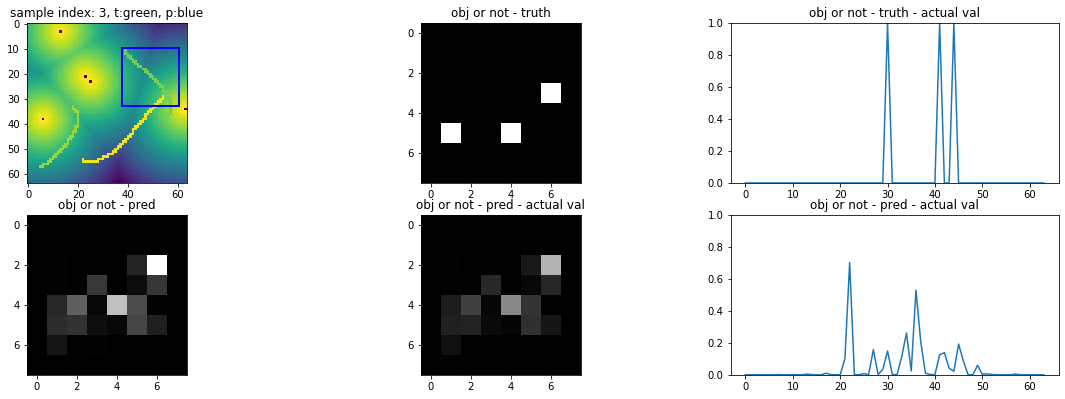

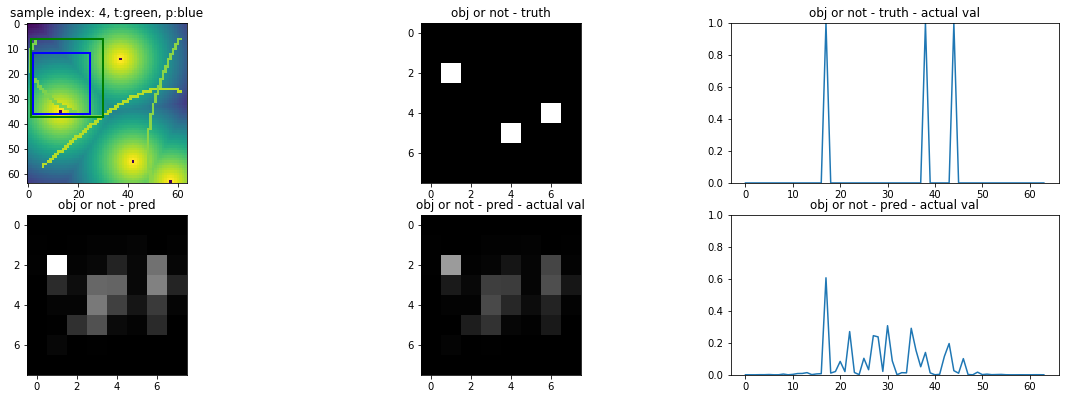

In [217]:
x_0, y_0, y_1 = x_test, y_test0, y_test1
#x_0, y_0, y_1 = x_train, y_train0, y_train1
#x_0, y_0, y_1 = x_val, y_val0, y_val1
pred = model.predict(x_0)
pred = [pred]
viz_results(x_0,y_0,y_1,pred,szx,szy)

In [19]:
# !CUDA_VISIBLE_DEVICES=0 python line-yolo-hyper-param-search.py

In [24]:
from keras.models import load_model

best_model = load_model(
    'line-yolo-model.h5',
   custom_objects={
       'vec_loss':vec_loss,
       'compute_iou_loss':compute_iou_loss,
       'compute_coord_loss':compute_coord_loss,
       'compute_obj_loss':compute_obj_loss,
   },
)
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_651 (Conv2D)          (None, 32, 32, 32)        288       
_________________________________________________________________
batch_normalization_456 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_456 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_456 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_652 (Conv2D)          (None, 16, 16, 16)        4608      
_________________________________________________________________
batch_normalization_457 (Bat (None, 16, 16, 16)        64        
__________

10/10 [==============================] - 0s 2ms/step
train 0.10103714466094971
10/10 [==============================] - 0s 342us/step
val 0.09184965491294861
5/5 [==============================] - 0s 664us/step
test 0.14512260258197784
(1, 2)
None [6 6]
pred [0.18265721 0.15446779 0.19427028 0.02465883 0.28168994]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [4 6]
pred [0.19871023 0.18521881 0.2865039  0.0577707  0.25699985]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [3 6]
pred [0.09939745 0.18271425 0.4542588  0.0032053  0.39703888]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [4 5]
pred [0.08402789 0.3967472  0.7860595  0.23175389 0.35620093]
true [0.0625    0.1015625 0.3125    0.359375  1.       ]
------
(1, 2)
None [1 5]
pred [0.1589221  0.20100918 0.23969886 0.02767518 0.42356578]
true [0. 0. 0. 0. 0.]
------


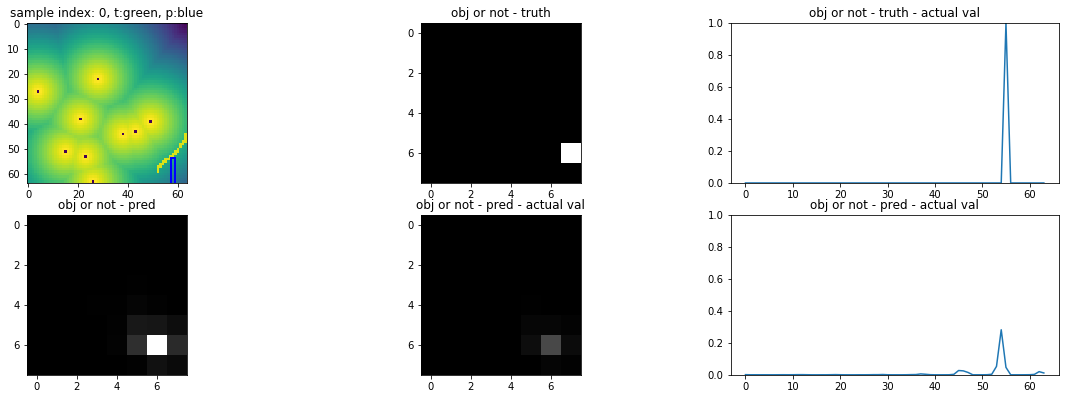

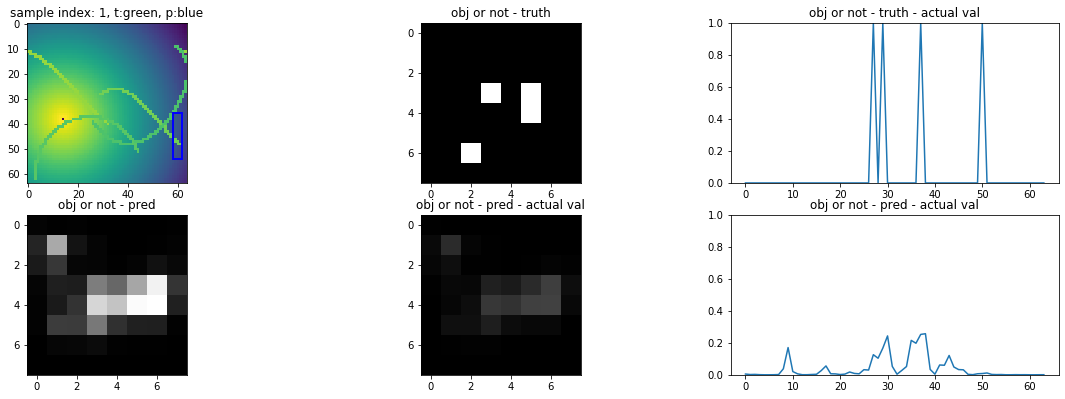

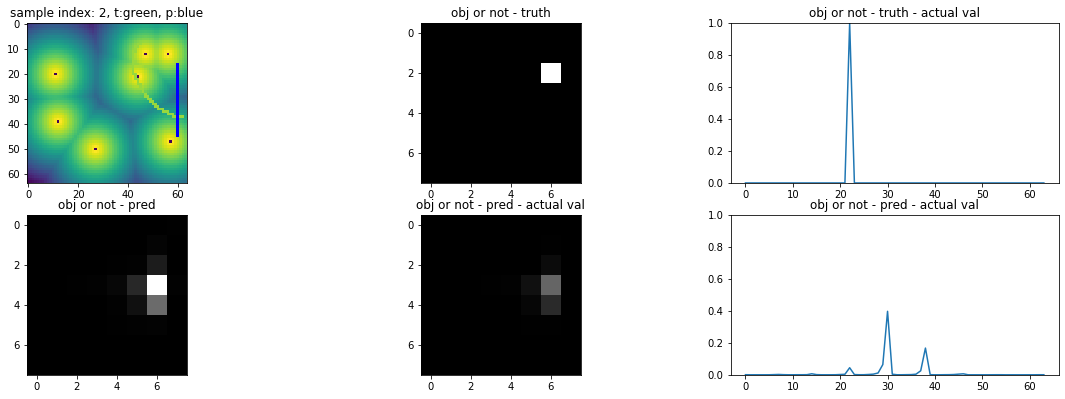

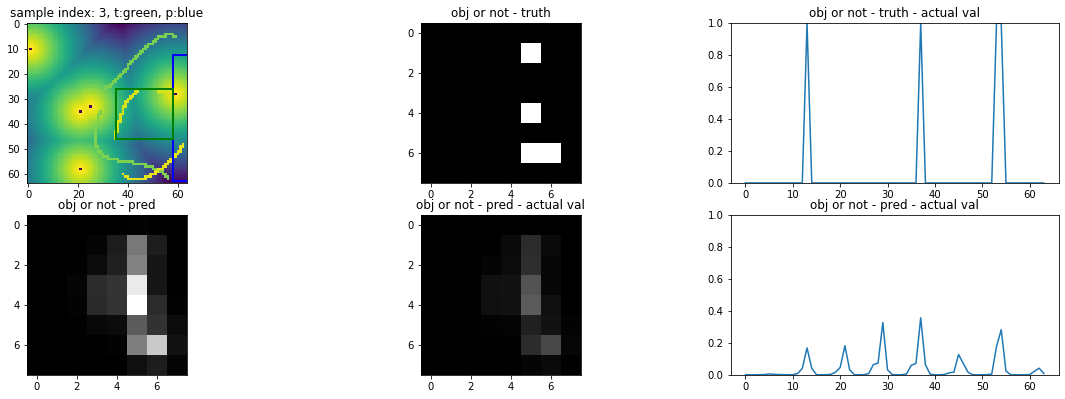

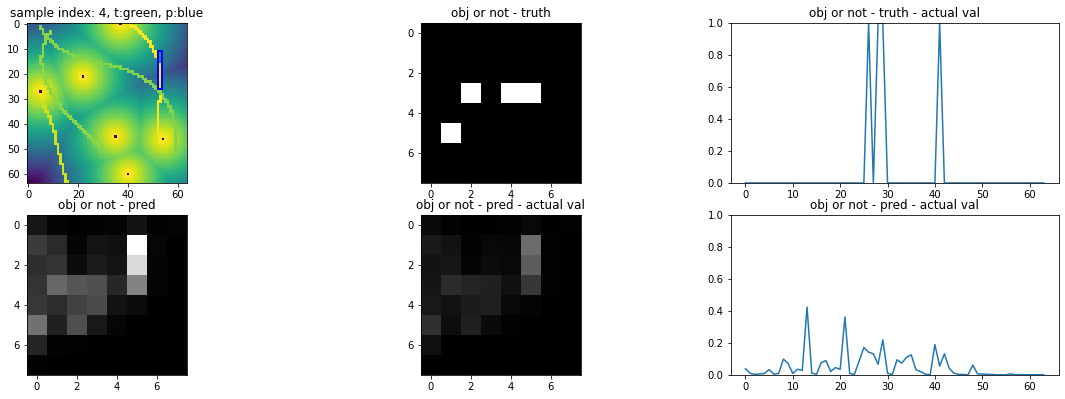

In [23]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = best_model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = best_model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = best_model.evaluate(x_0,y_0)
print('test',out)

x_0, y_0, y_1 = x_train, y_train0, y_train1
x_0, y_0, y_1 = x_test, y_test0, y_test1
pred = best_model.predict(x_0)
viz_results(x_0,y_0,y_1,[pred],szx,szy)